In [1]:
import pandas as pd
import numpy as np
from pyomo import environ
from pyomo.environ import *
np.random.seed(0)
from utils import *
from dnn import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
nutr_val = pd.read_excel('Data/Syria_instance.xlsx', sheet_name='nutr_val', index_col='Food', engine='openpyxl')
nutr_req = pd.read_excel('Data/Syria_instance.xlsx', sheet_name='nutr_req', index_col='Type', engine='openpyxl')
cost_p = pd.read_excel('Data/Syria_instance.xlsx', sheet_name='FoodCost', index_col='Supplier', engine='openpyxl').iloc[0,:]
dataset = pd.read_csv('Data/WFP_dataset.csv').sample(frac=1)

y = dataset['label']
X = dataset.drop(['label'], axis=1, inplace=False)

dataset

,Beans,Bulgur,Cheese,Fish,Meat,CSB,Dates,DSM,Milk,Salt,...,Soya-fortified bulgur wheat,Soya-fortified maize meal,Soya-fortified sorghum grits,Soya-fortified wheat flour,Sugar,Oil,Wheat,Wheat flour,WSB,label
398,0.687675,1.257354,0.000000,0.0,0.0,0.000000,0.000000,0.302104,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.357429,2.823603,0.000000,0.637964,0.715428
3833,0.551125,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.117990,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.392274,2.540599,3.414615,0.733300,0.292719
4836,0.701614,0.000000,0.000000,0.0,0.0,0.094990,0.000000,0.330808,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.221908,0.336647,0.000000,0.545864,0.816616
4572,0.000000,3.832166,0.000000,0.0,0.0,0.000000,0.626751,0.278648,0.132718,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.311117,0.000000,0.000000,0.694007,0.794680
636,0.039754,0.000000,0.344293,0.0,0.0,0.000000,0.000000,0.106482,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.160220,0.000000,0.000000,0.788790,0.261417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.743757,0.000000,0.115426,0.0,0.0,0.700000,0.000000,0.479955,0.000000,0.05,...,0.0,0.041521,0.0,0.0,0.2,0.181913,0.000000,0.000000,0.000000,0.210851
3264,0.779749,0.000000,0.075277,0.0,0.0,0.761232,0.000000,0.392905,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.178567,0.000000,0.000000,0.029013,0.293570
1653,0.668713,3.322546,0.000000,0.0,0.0,0.429041,0.000000,0.450216,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.271382,0.000000,0.000000,0.189249,0.813417
2607,0.460621,1.464405,0.160834,0.0,0.0,0.757835,0.000000,0.391194,0.000000,0.05,...,0.0,0.000000,0.0,0.0,0.2,0.166244,0.000000,0.000000,0.000000,0.382687


## Optimization problem

In [3]:
def init_conceptual_model(cost_p):
    N = list(nutr_val.index)  # foods
    M = nutr_req.columns  # nutrient requirements

    model = ConcreteModel('TPDP')

    '''
    Decision variables
    '''
    model.x = Var(N, domain=NonNegativeReals)  # variables controlling the food basket

    '''
    Objective function.
    '''
    def obj_function(model):
        return sum(cost_p[food].item()*model.x[food] for food in N)

    model.OBJ = Objective(rule=obj_function, sense=minimize)

    '''
    Nutrients requirements constraint.
    '''
    def constraint_rule1(model, req):
        return sum(model.x[food] * nutr_val.loc[food, req] for food in N) >= nutr_req[req].item()
    model.Constraint1 = Constraint(M, rule=constraint_rule1)
    '''
    Sugar constraint
    '''
    def constraint_rule2(model):
        return model.x['Sugar'] == 0.2
    model.Constraint2 = Constraint(rule=constraint_rule2)
    '''
    Salt constraint
    '''
    def constraint_rule3(model):
        return model.x['Salt'] == 0.05
    model.Constraint3 = Constraint(rule=constraint_rule3)
    
    return model

## Chance constraint learning

#### Point

In [4]:
from CCL import CCL

ccl_tool = CCL(X, y, methodology='point', p_model='nn')
model = ccl_tool.train()
cons = ccl_tool.constraint_build(model)
conceptual_model= init_conceptual_model(cost_p)
ccl_tool.const_embed(conceptual_model, cons, 'palatability', lb=0.5)
#conceptual_model.pprint()

NN fitting process finished, with a test MSE/Qloss of 0.00012560893082991242 in epoch 5137


In [5]:
opt = SolverFactory('gurobi')
opt.options['threads'] = 8
results = opt.solve(conceptual_model) 
solution = {}
sol_point = {}
for food in  list(nutr_val.index):
    sol_point[food] = value(conceptual_model.x[food])
    if value(conceptual_model.x[food])*100 > 0.0000001:
        solution[food] = str(np.round(value(conceptual_model.x[food])*100, 2))+'g'
print('The optimal solution is: \n', solution)
print(f"The cost for the optimal solution is {np.round(value(conceptual_model.OBJ),2)} euros")

The optimal solution is: 
 {'Milk': '45.74g', 'Salt': '5.0g', 'Lentils': '32.87g', 'Maize': '99.94g', 'Sugar': '20.0g', 'Oil': '21.66g', 'Wheat': '280.54g', 'WSB': '74.69g'}
The cost for the optimal solution is 3258.9 euros


#### Quantile

In [6]:
from CCL import CCL

ccl_tool = CCL(X, y, methodology='quantile', p_model='nn', q=0.05)
model = ccl_tool.train()
cons = ccl_tool.constraint_build(model)
conceptual_model= init_conceptual_model(cost_p)
ccl_tool.const_embed(conceptual_model, cons, 'palatability', lb=0.5)
#conceptual_model.pprint()

NN fitting process finished, with a test MSE/Qloss of 0.0012673898600041866 in epoch 4807


In [7]:
opt = SolverFactory('gurobi')
opt.options['threads'] = 8
results = opt.solve(conceptual_model) 
solution = {}
sol_quantile = {}
for food in  list(nutr_val.index):
    sol_quantile[food] = value(conceptual_model.x[food])
    if value(conceptual_model.x[food])*100 > 0.0000001:
        solution[food] = str(np.round(value(conceptual_model.x[food])*100, 2))+'g'
print('The optimal solution is: \n', solution)
print(f"The cost for the optimal solution is {np.round(value(conceptual_model.OBJ),2)} euros")

The optimal solution is: 
 {'Milk': '45.55g', 'Salt': '5.0g', 'Lentils': '34.16g', 'Maize': '98.53g', 'Sugar': '20.0g', 'Oil': '21.7g', 'Wheat': '280.68g', 'WSB': '74.79g'}
The cost for the optimal solution is 3260.78 euros


#### Superquantile

In [8]:
from CCL import CCL

ccl_tool = CCL(X, y, methodology='superquantile', p_model='nn', q=0.05, side='left', M_super=5)
model = ccl_tool.train()
cons = ccl_tool.constraint_build(model)
conceptual_model= init_conceptual_model(cost_p)
ccl_tool.const_embed(conceptual_model, cons, 'palatability', lb=0.5)
#conceptual_model.pprint()

NN fitting process finished, with a test MSE/Qloss of 0.001402083900757134 in epoch 4566


In [9]:
opt = SolverFactory('gurobi')
opt.options['threads'] = 8
results = opt.solve(conceptual_model) 
solution = {}
sol_superq = {}
for food in  list(nutr_val.index):
    sol_superq[food] = value(conceptual_model.x[food])
    if value(conceptual_model.x[food])*100 > 0.0000001:
        solution[food] = str(np.round(value(conceptual_model.x[food])*100, 2))+'g'
print('The optimal solution is: \n', solution)
print(f"The cost for the optimal solution is {np.round(value(conceptual_model.OBJ),2)} euros")

The optimal solution is: 
 {'Milk': '44.85g', 'Salt': '5.0g', 'Lentils': '38.97g', 'Maize': '93.28g', 'Sugar': '20.0g', 'Oil': '21.86g', 'Wheat': '281.19g', 'WSB': '75.18g'}
The cost for the optimal solution is 3267.78 euros


### Validation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
output_feature = "y"
X_train['y'] = y_train.values
X_test['y'] = y_test.values
train_ds = TabularDataset(data=X_train, output_col=output_feature)
test_ds = TabularDataset(data=X_test, output_col=output_feature)
batchsize = 64
train_dl = DataLoader(train_ds, batch_size = batchsize, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds))
lr = 1e-3
seed = 0
torch.cuda.empty_cache()
np.random.seed(seed)
torch.manual_seed(seed)

quants = np.linspace(0.5, 100, num=20, endpoint=False)
quantiles = quants/100
model = FeedForwardNN(no_of_cont=X.shape[1], lin_layer_sizes=[100 for i in range(2)], output_size=len(quantiles),
                                        lin_layer_dropouts=[0.05 for i in range(2)]).to(device)
model.apply(weights_init)
criterion = QuantileLoss(quantiles=quantiles)
optimizer = optim.Adam(model.parameters(), lr = lr)

best_loss = 1000
for epoch in range(8000):
    ###### Training ######
    model = model.train()
    for y, cont_x in train_dl:
        optimizer.zero_grad()
        cont_x = cont_x.to(device)
        y  = y.to(device)
        output_t = model(cont_x)
        loss = criterion(output_t, y)
        loss.backward()
        optimizer.step()
    
    ###### Validation ######
    model = model.eval()
    test_loss = 0
    with torch.no_grad():
        for y, cont_x in test_dl:
            cont_x = cont_x.to(device)
            y  = y.to(device)
            output_test = model(cont_x)
            loss = criterion(output_test, y) 
            test_loss += loss.item()
    
    test_loss /= float(len(test_dl))
    if test_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_q.pt')
        best_loss = test_loss
        last_save = epoch

model.load_state_dict(torch.load('best_model_q.pt'))



<All keys matched successfully>

In [11]:
model = model.eval()
with torch.no_grad():
    output_point = model(torch.tensor(list(sol_point.values())).to(device)).detach().numpy()
    output_quantile = model(torch.tensor(list(sol_quantile.values())).to(device)).detach().numpy()
    output_superq = model(torch.tensor(list(sol_superq.values())).to(device)).detach().numpy()

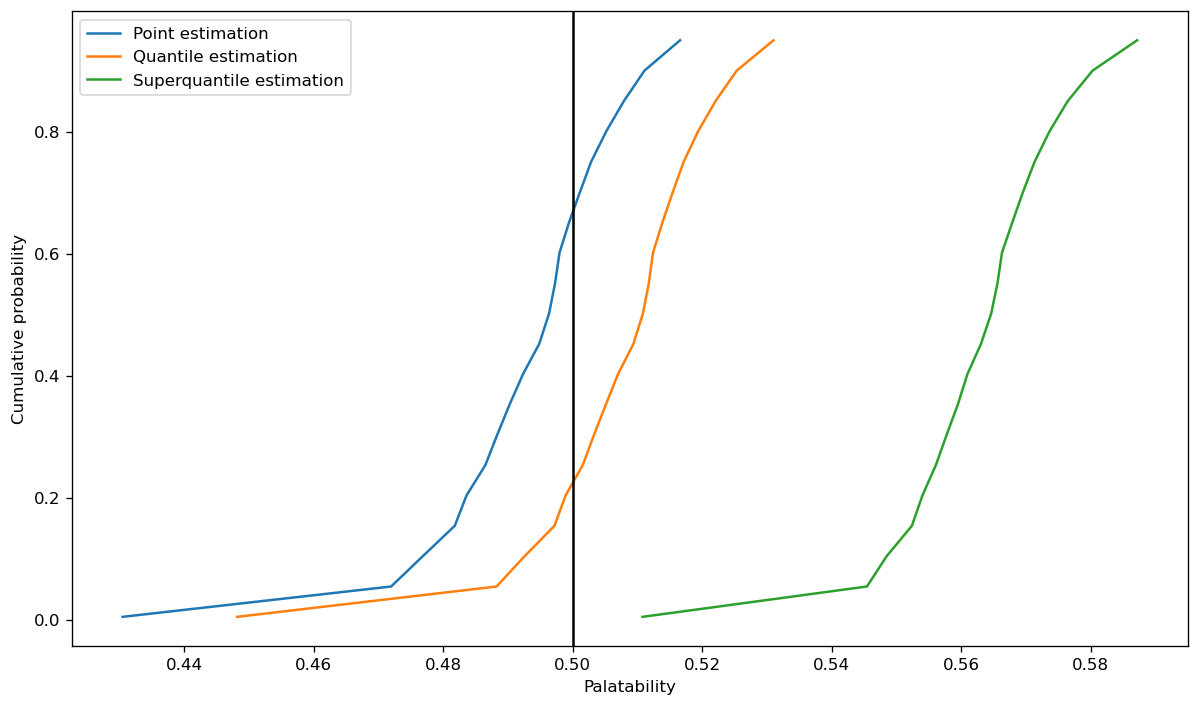

In [12]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
plt.plot(output_point, quantiles, label='Point estimation')
plt.plot(output_quantile, quantiles, label='Quantile estimation')
plt.plot(output_superq, quantiles, label='Superquantile estimation')
plt.axvline(x=0.5, color = 'black')
plt.ylabel('Cumulative probability')
plt.xlabel('Palatability')
plt.legend()
plt.show()